<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/Forward_Forward_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.compiler.tf2xla.python import xla
import tensorflow_probability as tfp


4 Random Training samples and labels


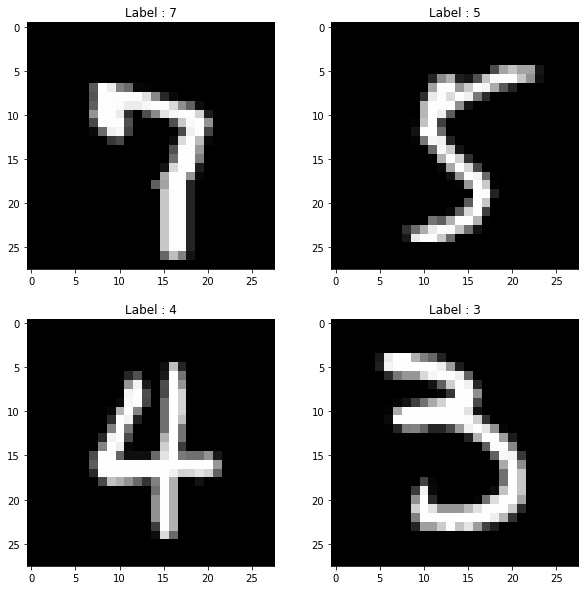

In [ ]:
# load the data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("4 Random Training samples and labels")
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4)

img1 = (x_train[idx1], y_train[idx1])
img2 = (x_train[idx2], y_train[idx2])
img3 = (x_train[idx3], y_train[idx3])
img4 = (x_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(10, 10))

for idx, item in enumerate(imgs):
    image, label = item[0], item[1]
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()


In [ ]:
# preproc dataset

x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)


In [ ]:
# define a ff dense
class FFDense(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Dense layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=50,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    # We perform a normalization step before we run the input through the Dense
    # layer.

    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.dense(x_dir)
        return self.relu(res)

    # The Forward-Forward algorithm is below. We first perform the Dense-layer
    # operation and then get a Mean Square value for all positive and negative
    # samples respectively.
    # The custom loss function finds the distance between the Mean-squared
    # result and the threshold value we set (a hyperparameter) that will define
    # whether the prediction is positive or negative in nature. Once the loss is
    # calculated, we get a mean across the entire batch combined and perform a
    # gradient calculation and optimization step. This does not technically
    # qualify as backpropagation since there is no gradient being
    # sent to any previous layer and is completely local in nature.

    def forward_forward(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                g_pos = tf.math.reduce_mean(tf.math.pow(self.call(x_pos), 2), 1)
                g_neg = tf.math.reduce_mean(tf.math.pow(self.call(x_neg), 2), 1)

                loss = tf.math.log(
                    1
                    + tf.math.exp(
                        tf.concat([-g_pos + self.threshold, g_neg - self.threshold], 0)
                    )
                )
                mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
                self.loss_metric.update_state([mean_loss])
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )


In [ ]:
# create a full ff network
class FFNetwork(keras.Model):
    """
    A [`keras.Model`](/api/models/model#model-class) that supports a `FFDense` network creation. This model
    can work for any kind of classification task. It has an internal
    implementation with some details specific to the MNIST dataset which can be
    changed as per the use-case.
    """

    # Since each layer runs gradient-calculation and optimization locally, each
    # layer has its own optimizer that we pass. As a standard choice, we pass
    # the `Adam` optimizer with a default learning rate of 0.03 as that was
    # found to be the best rate after experimentation.
    # Loss is tracked using `loss_var` and `loss_count` variables.
    # Use legacy optimizer for Layer Optimizer to fix issue
    # https://github.com/keras-team/keras-io/issues/1241

    def __init__(
        self,
        dims,
        layer_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.03),
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = [keras.Input(shape=(dims[0],))]
        for d in range(len(dims) - 1):
            self.layer_list += [
                FFDense(
                    dims[d + 1],
                    optimizer=self.layer_optimizer,
                    loss_metric=keras.metrics.Mean(),
                )
            ]

    # This function makes a dynamic change to the image wherein the labels are
    # put on top of the original image (for this example, as MNIST has 10
    # unique labels, we take the top-left corner's first 10 pixels). This
    # function returns the original data tensor with the first 10 pixels being
    # a pixel-based one-hot representation of the labels.

    @tf.function(reduce_retracing=True)
    def overlay_y_on_x(self, data):
        X_sample, y_sample = data
        max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
        max_sample = tf.cast(max_sample, dtype=tf.float64)
        X_zeros = tf.zeros([10], dtype=tf.float64)
        X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
        X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
        return X_sample, y_sample

    # A custom `predict_one_sample` performs predictions by passing the images
    # through the network, measures the results produced by each layer (i.e.
    # how high/low the output values are with respect to the set threshold for
    # each label) and then simply finding the label with the highest values.
    # In such a case, the images are tested for their 'goodness' with all
    # labels.

    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = []
        x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]])
        for label in range(10):
            h, label = self.overlay_y_on_x(data=(x, label))
            h = tf.reshape(h, [-1, tf.shape(h)[0]])
            goodness = []
            for layer_idx in range(1, len(self.layer_list)):
                layer = self.layer_list[layer_idx]
                h = layer(h)
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)

    # This custom `train_step` function overrides the internal `train_step`
    # implementation. We take all the input image tensors, flatten them and
    # subsequently produce positive and negative samples on the images.
    # A positive sample is an image that has the right label encoded on it with
    # the `overlay_y_on_x` function. A negative sample is an image that has an
    # erroneous label present on it.
    # With the samples ready, we pass them through each `FFLayer` and perform
    # the Forward-Forward computation on it. The returned loss is the final
    # loss value over all the layers.

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Flatten op
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])

        x_pos, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, y))

        random_y = tf.random.shuffle(y)
        x_neg, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, random_y))

        h_pos, h_neg = x_pos, x_neg

        for idx, layer in enumerate(self.layers):
            if isinstance(layer, FFDense):
                print(f"Training layer {idx+1} now : ")
                h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Passing layer {idx+1} now : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}


In [ ]:
model = FFNetwork(dims=[784, 500, 500])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[keras.metrics.Mean()],
)

epochs = 250
history = model.fit(train_dataset, epochs=epochs)


Epoch 1/250
Training layer 1 now : 
Training layer 2 now : 
Training layer 1 now : 
Training layer 2 now : 
1/1 [==============================] - 101s 101s/step - FinalLoss: 0.7279
Epoch 2/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.7082
Epoch 3/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.7022
Epoch 4/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6796
Epoch 5/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6565
Epoch 6/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6347
Epoch 7/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6152
Epoch 8/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5983
Epoch 9/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5831
Epoch 10/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5697
Epoch 11/250
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5

Test Accuracy score : 97.72999999999999%


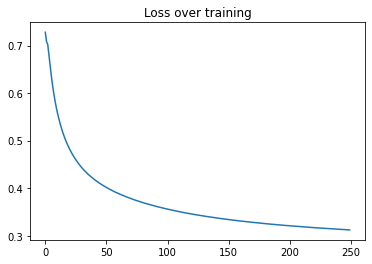

In [ ]:
# inference and testing
preds = model.predict(tf.convert_to_tensor(x_test))

preds = preds.reshape((preds.shape[0], preds.shape[1]))

results = accuracy_score(preds, y_test)

print(f"Test Accuracy score : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()


Reshaped VERSION WITH Y SIGNAL

In [ ]:
# define a ff dense
class FFDense(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Dense layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=50,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    # We perform a normalization step before we run the input through the Dense
    # layer.

    @tf.function
    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_dir = x / (x_norm + 1e-4)
        res = self.dense(x_dir)
        return tf.nn.relu(res)

    # The Forward-Forward algorithm is below. We first perform the Dense-layer
    # operation and then get a Mean Square value for all positive and negative
    # samples respectively.
    # The custom loss function finds the distance between the Mean-squared
    # result and the threshold value we set (a hyperparameter) that will define
    # whether the prediction is positive or negative in nature. Once the loss is
    # calculated, we get a mean across the entire batch combined and perform a
    # gradient calculation and optimization step. This does not technically
    # qualify as backpropagation since there is no gradient being
    # sent to any previous layer and is completely local in nature.

    @tf.function
    def forward_forward(self, x, y):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                xx = tf.reduce_mean(tf.square(self.call(x)), axis=1)
                r = y * (self.threshold - xx) + (1 - y) * (xx - self.threshold)
                loss = tf.math.log(1 + tf.math.exp(r))
                mean_loss = tf.reduce_mean(loss)
                self.loss_metric.update_state(mean_loss)
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return tf.stop_gradient(self.call(x)), self.loss_metric.result()

        

In [ ]:
# create a full ff network
class FFNetwork(keras.Model):
    """
    A [`keras.Model`](/api/models/model#model-class) that supports a `FFDense` network creation. This model
    can work for any kind of classification task. It has an internal
    implementation with some details specific to the MNIST dataset which can be
    changed as per the use-case.
    """

    # Since each layer runs gradient-calculation and optimization locally, each
    # layer has its own optimizer that we pass. As a standard choice, we pass
    # the `Adam` optimizer with a default learning rate of 0.03 as that was
    # found to be the best rate after experimentation.
    # Loss is tracked using `loss_var` and `loss_count` variables.
    # Use legacy optimizer for Layer Optimizer to fix issue
    # https://github.com/keras-team/keras-io/issues/1241

    def __init__(
        self,
        dims,
        layer_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.03),
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = [keras.Input(shape=(dims[0],))]
        for d in range(len(dims) - 1):
            self.layer_list += [
                FFDense(
                    dims[d + 1],
                    optimizer=self.layer_optimizer,
                    loss_metric=keras.metrics.Mean(),
                )
            ]

    # This function makes a dynamic change to the image wherein the labels are
    # put on top of the original image (for this example, as MNIST has 10
    # unique labels, we take the top-left corner's first 10 pixels). This
    # function returns the original data tensor with the first 10 pixels being
    # a pixel-based one-hot representation of the labels.

    @tf.function(reduce_retracing=True)
    def overlay_y_on_x(self, data):
        X_sample, y_sample = data
        max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
        max_sample = tf.cast(max_sample, dtype=tf.float64)
        X_zeros = tf.zeros([10], dtype=tf.float64)
        X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
        X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
        return X_sample, y_sample

    # A custom `predict_one_sample` performs predictions by passing the images
    # through the network, measures the results produced by each layer (i.e.
    # how high/low the output values are with respect to the set threshold for
    # each label) and then simply finding the label with the highest values.
    # In such a case, the images are tested for their 'goodness' with all
    # labels.

    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = []
        x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]])
        for label in range(10):
            h, label = self.overlay_y_on_x(data=(x, label))
            h = tf.reshape(h, [-1, tf.shape(h)[0]])
            goodness = []
            for layer_idx in range(1, len(self.layer_list)):
                layer = self.layer_list[layer_idx]
                h = layer(h)
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)

    # This custom `train_step` function overrides the internal `train_step`
    # implementation. We take all the input image tensors, flatten them and
    # subsequently produce positive and negative samples on the images.
    # A positive sample is an image that has the right label encoded on it with
    # the `overlay_y_on_x` function. A negative sample is an image that has an
    # erroneous label present on it.
    # With the samples ready, we pass them through each `FFLayer` and perform
    # the Forward-Forward computation on it. The returned loss is the final
    # loss value over all the layers.

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Flatten op
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])

        x_pos, _ = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, y))

        random_y = tf.random.shuffle(y)
        x_neg, _ = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, random_y))

        xx = tf.concat([x_pos, x_neg], axis=0)
        yy = tf.concat([tf.ones(len(x_pos), dtype=tf.float32),
                        tf.zeros(len(x_neg), dtype=tf.float32)], axis=0)

        for idx, layer in enumerate(self.layers):
            if isinstance(layer, FFDense):
                print(f"Training layer {idx+1} now : ")
                xx, loss = layer.forward_forward(xx, yy)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Passing layer {idx+1} now : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}


In [ ]:
model = FFNetwork(dims=[784, 500, 500])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[keras.metrics.Mean()],
)

epochs = 100
history = model.fit(train_dataset, epochs=epochs)


Epoch 1/100
Training layer 1 now : 
Training layer 2 now : 
1/1 [==============================] - 65s 65s/step - FinalLoss: 0.7171
Epoch 2/100
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6886
Epoch 3/100
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.6665
Epoch 4/100
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.6414
Epoch 5/100
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.6193
Epoch 6/100
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.5994
Epoch 7/100
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.5823
Epoch 8/100
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5674
Epoch 9/100
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.5545
Epoch 10/100
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.5426
Epoch 11/100
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.5324
Epoch 12/100
1/1 [============================

In [ ]:
# inference and testing
preds = model.predict(tf.convert_to_tensor(x_test))

preds = preds.reshape((preds.shape[0], preds.shape[1]))

results = accuracy_score(preds, y_test)

print(f"Test Accuracy score : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()


NameError: ignored

## unsupervised


In [ ]:

# define a ff dense
class FFDense(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Dense layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=50,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    # We perform a normalization step before we run the input through the Dense
    # layer.

    #@tf.function
    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_dir = x / (x_norm + 1e-4)
        res = self.dense(x_dir)
        return tf.nn.relu(res)

    # The Forward-Forward algorithm is below. We first perform the Dense-layer
    # operation and then get a Mean Square value for all positive and negative
    # samples respectively.
    # The custom loss function finds the distance between the Mean-squared
    # result and the threshold value we set (a hyperparameter) that will define
    # whether the prediction is positive or negative in nature. Once the loss is
    # calculated, we get a mean across the entire batch combined and perform a
    # gradient calculation and optimization step. This does not technically
    # qualify as backpropagation since there is no gradient being
    # sent to any previous layer and is completely local in nature.

    @tf.function
    def mahalanobis_distance(self, x):
        mean, var = tf.nn.moments(x, axes=0)
        cov = tfp.stats.covariance(x, sample_axis=0, event_axis=-1)
        inv_cov = tf.linalg.pinv(cov)
        diff = x - mean
        md = tf.reduce_sum(tf.matmul(diff, inv_cov) * diff, axis=1)
        return md

    @tf.function
    def euclidean_distance(self, x):
        center = tf.reduce_mean(x, axis=0)
        distances = tf.norm(x - center, axis=1)
        return distances


    @tf.function
    def forward_forward(self, x, y=None):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                drive = self.call(x)
                xx = tf.reduce_mean(tf.square(drive), axis=1)
                if y == None:
                  md = tf.math.abs(self.euclidean_distance(drive))
                  y = 1. - md / tf.reduce_max(md)
                r = y * (self.threshold - xx) + (1 - y) * (xx - self.threshold)
                loss = tf.math.log(1 + tf.math.exp(r))
                mean_loss = tf.reduce_mean(loss)
                self.loss_metric.update_state(mean_loss)
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return tf.stop_gradient(self.call(x)), self.loss_metric.result()

In [ ]:
# create a full ff network
class FFNetwork(keras.Model):
    """
    A [`keras.Model`](/api/models/model#model-class) that supports a `FFDense` network creation. This model
    can work for any kind of classification task. It has an internal
    implementation with some details specific to the MNIST dataset which can be
    changed as per the use-case.
    """

    # Since each layer runs gradient-calculation and optimization locally, each
    # layer has its own optimizer that we pass. As a standard choice, we pass
    # the `Adam` optimizer with a default learning rate of 0.03 as that was
    # found to be the best rate after experimentation.
    # Loss is tracked using `loss_var` and `loss_count` variables.
    # Use legacy optimizer for Layer Optimizer to fix issue
    # https://github.com/keras-team/keras-io/issues/1241

    def __init__(
        self,
        dims,
        layer_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.03),
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = [keras.Input(shape=(dims[0],))]
        for d in range(len(dims) - 1):
            self.layer_list += [
                FFDense(
                    dims[d + 1],
                    optimizer=self.layer_optimizer,
                    loss_metric=keras.metrics.Mean(),
                )
            ]

    # This function makes a dynamic change to the image wherein the labels are
    # put on top of the original image (for this example, as MNIST has 10
    # unique labels, we take the top-left corner's first 10 pixels). This
    # function returns the original data tensor with the first 10 pixels being
    # a pixel-based one-hot representation of the labels.

    @tf.function(reduce_retracing=True)
    def overlay_y_on_x(self, data):
        X_sample, y_sample = data
        max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
        max_sample = tf.cast(max_sample, dtype=tf.float64)
        X_zeros = tf.zeros([10], dtype=tf.float64)
        X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
        X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
        return X_sample, y_sample

    # A custom `predict_one_sample` performs predictions by passing the images
    # through the network, measures the results produced by each layer (i.e.
    # how high/low the output values are with respect to the set threshold for
    # each label) and then simply finding the label with the highest values.
    # In such a case, the images are tested for their 'goodness' with all
    # labels.

    def call(self, x):
      x = tf.reshape(x, [-1, tf.shape(x)[0] * tf.shape(x)[1]])
      for layer in self.layer_list:
        x = layer(x)

      return x

    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = []
        x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]])
        for label in range(10):
            h, label = self.overlay_y_on_x(data=(x, label))
            h = tf.reshape(h, [-1, tf.shape(h)[0]])
            goodness = []
            for layer_idx in range(1, len(self.layer_list)):
                layer = self.layer_list[layer_idx]
                h = layer(h)
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)

    # This custom `train_step` function overrides the internal `train_step`
    # implementation. We take all the input image tensors, flatten them and
    # subsequently produce positive and negative samples on the images.
    # A positive sample is an image that has the right label encoded on it with
    # the `overlay_y_on_x` function. A negative sample is an image that has an
    # erroneous label present on it.
    # With the samples ready, we pass them through each `FFLayer` and perform
    # the Forward-Forward computation on it. The returned loss is the final
    # loss value over all the layers.

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Flatten op
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])

        x_pos, _ = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, y))

        random_y = tf.random.shuffle(y)
        x_neg, _ = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, random_y))

        xx = tf.concat([x_pos, x_neg], axis=0)

        for idx, layer in enumerate(self.layers):
            if isinstance(layer, FFDense):
                print(f"Training layer {idx+1} now : ")
                xx, loss = layer.forward_forward(xx, y=None)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Passing layer {idx+1} now : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}
#r = model.layers[0](tf.reshape(tf.convert_to_tensor(x_test[:128]), [-1, 28*28]))

In [ ]:
# train
model = FFNetwork(dims=[784, 500, 500])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[keras.metrics.Mean()],
)

epochs = 2
history = model.fit(train_dataset, epochs=epochs)


Epoch 1/2
Training layer 1 now : 
Training layer 2 now : 
1/1 [==============================] - 64s 64s/step - FinalLoss: 0.4373
Epoch 2/2
1/1 [==============================] - 39s 39s/step - FinalLoss: 0.3870


In [ ]:
x = tf.reshape(tf.convert_to_tensor(x_test[:128]), [-1, 28*28])

r = model.layers[0](x)
r

<tf.Tensor: shape=(128, 500), dtype=float32, numpy=
array([[1.2219908 , 4.391045  , 0.        , ..., 0.        , 0.06396344,
        0.        ],
       [2.7021596 , 4.301476  , 0.        , ..., 0.        , 0.43858445,
        0.17932157],
       [1.4623371 , 3.848335  , 1.0635747 , ..., 0.        , 0.6206826 ,
        0.        ],
       ...,
       [2.1090364 , 4.1114864 , 0.13470346, ..., 0.        , 1.2836194 ,
        0.12334886],
       [2.6825938 , 3.9775226 , 0.        , ..., 0.        , 0.05443571,
        0.02138174],
       [1.9457905 , 4.857208  , 0.        , ..., 0.        , 1.7707671 ,
        0.        ]], dtype=float32)>

Test Accuracy score : 11.35%


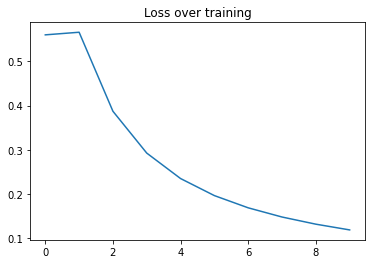

In [ ]:
# inference and testing
preds = model(tf.convert_to_tensor(x_test))

preds = preds.reshape((preds.shape[0], preds.shape[1]))

results = accuracy_score(preds, y_test)

print(f"Test Accuracy score : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()
